In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.api as tsa
from statsmodels.tsa.stattools import adfuller
from fsf_arima_models import ArimaModels
from fsf_arima_models_viz import ArimaModelsViz

## Get and massage portfolio data

In [2]:
ticker_histories_filename = os.path.join("input", "Tickers 2025-03-22.csv")
ticker_histories_df = pd.read_csv(ticker_histories_filename)
ticker_histories_df.set_index("datetime", inplace=True)
ticker_histories_df.sort_index(inplace=True)
ticker_histories_df

,ticker,open,high,low,close,volume,vwap,transactions
datetime,,,,,,,,
2025-01-23 05:00:00,AAPL,224.740,227.03,222.3000,223.66,57755057.0,224.1269,619710
2025-01-23 05:00:00,NVDA,145.050,147.23,143.7200,147.22,153298302.0,145.8249,1198252
2025-01-23 05:00:00,MSFT,442.000,446.75,441.5048,446.71,16975809.0,444.7685,281253
2025-01-23 05:00:00,GOOG,199.980,201.94,196.8200,199.58,14549698.0,199.7503,211391
2025-01-23 05:00:00,AMZN,234.100,235.52,231.5100,235.42,25806969.0,234.2066,365072
...,...,...,...,...,...,...,...,...
2025-03-21 04:00:00,MSFT,383.215,391.74,382.8000,391.26,37105109.0,387.7336,312574
2025-03-21 04:00:00,AMZN,192.900,196.99,192.5200,196.21,54674795.0,195.2121,394562
2025-03-21 04:00:00,AAPL,211.560,218.84,211.2800,218.27,89486162.0,215.7709,496690


In [3]:
adj_close_df = ticker_histories_df.reset_index().pivot(
    index="datetime", columns="ticker", values="close"
)
adj_close_df.index = pd.DatetimeIndex(adj_close_df.index)
adj_close_df.index = pd.DatetimeIndex(
    [dt.replace(hour=17, minute=0, second=0) for dt in adj_close_df.index]
)
adj_close_df

ticker,AAPL,AMZN,GOOG,MSFT,NVDA,TSLA
2025-01-23 17:00:00,223.66,235.42,199.58,446.71,147.22,412.38
2025-01-24 17:00:00,222.78,234.85,201.90,444.06,142.62,406.58
2025-01-27 17:00:00,229.86,235.42,193.77,434.56,118.42,397.15
2025-01-28 17:00:00,238.26,238.15,197.07,447.20,128.99,398.09
2025-01-29 17:00:00,239.36,237.07,197.18,442.33,123.70,389.10
2025-01-30 17:00:00,237.59,234.64,202.63,414.99,124.65,400.28
2025-01-31 17:00:00,236.00,237.68,205.60,415.06,120.07,404.60
2025-02-03 17:00:00,228.01,237.42,202.64,410.92,116.66,383.68
2025-02-04 17:00:00,232.80,242.06,207.71,412.37,118.65,392.21
2025-02-05 17:00:00,232.47,236.17,193.30,413.29,124.83,378.17


In [4]:
ticker_decomps = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close = adj_close.asfreq("B", method="ffill")
    components = tsa.seasonal_decompose(adj_close, model="additive")
    adj_close_decomp_df = (
        adj_close.to_frame("original")
        .assign(trend=components.trend)
        .assign(seasonal=components.seasonal)
        .assign(residual=components.resid)
    )
    ticker_decomps[ticker] = adj_close_decomp_df

## Plot the trends for each ticker

In [5]:
def plot_decomp(df, title):
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title("Original")
    axs[1].plot(df["trend"], color="orange")
    axs[1].set_title("Trend")
    axs[2].plot(df["seasonal"], color="green")
    axs[2].set_title("Seasonal")
    axs[3].plot(df["residual"], color="red")
    axs[3].set_title("Residual")
    fig.suptitle(title, fontsize=14)
    plt.tight_layout()

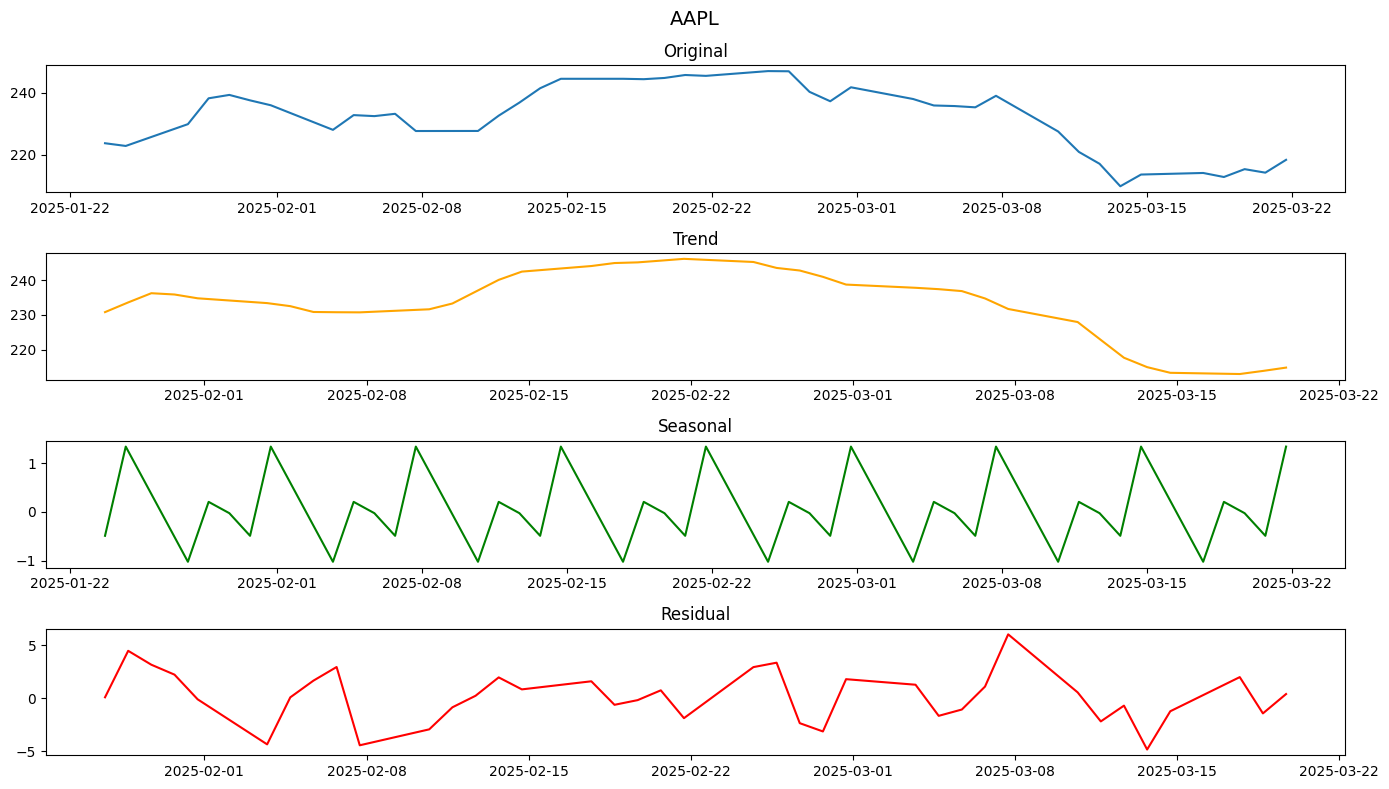

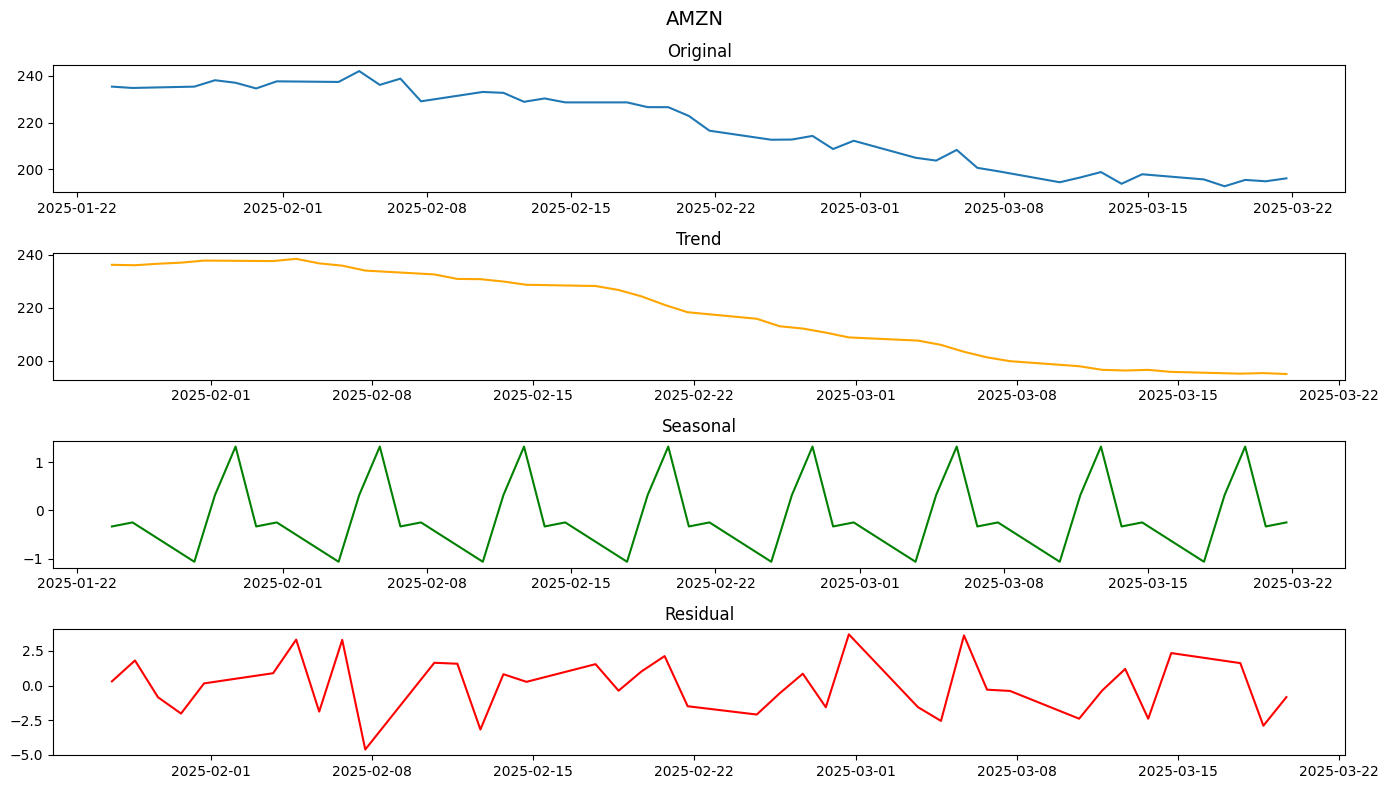

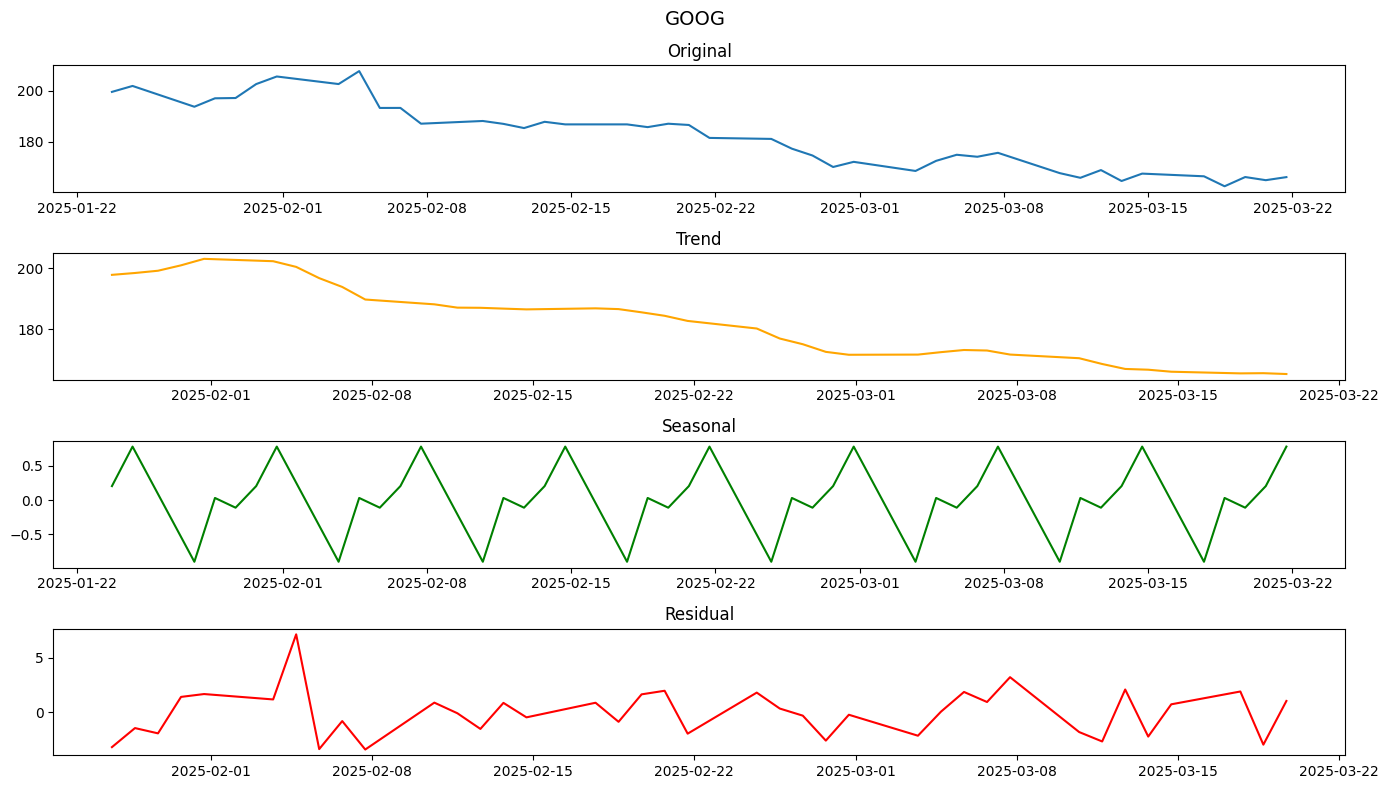

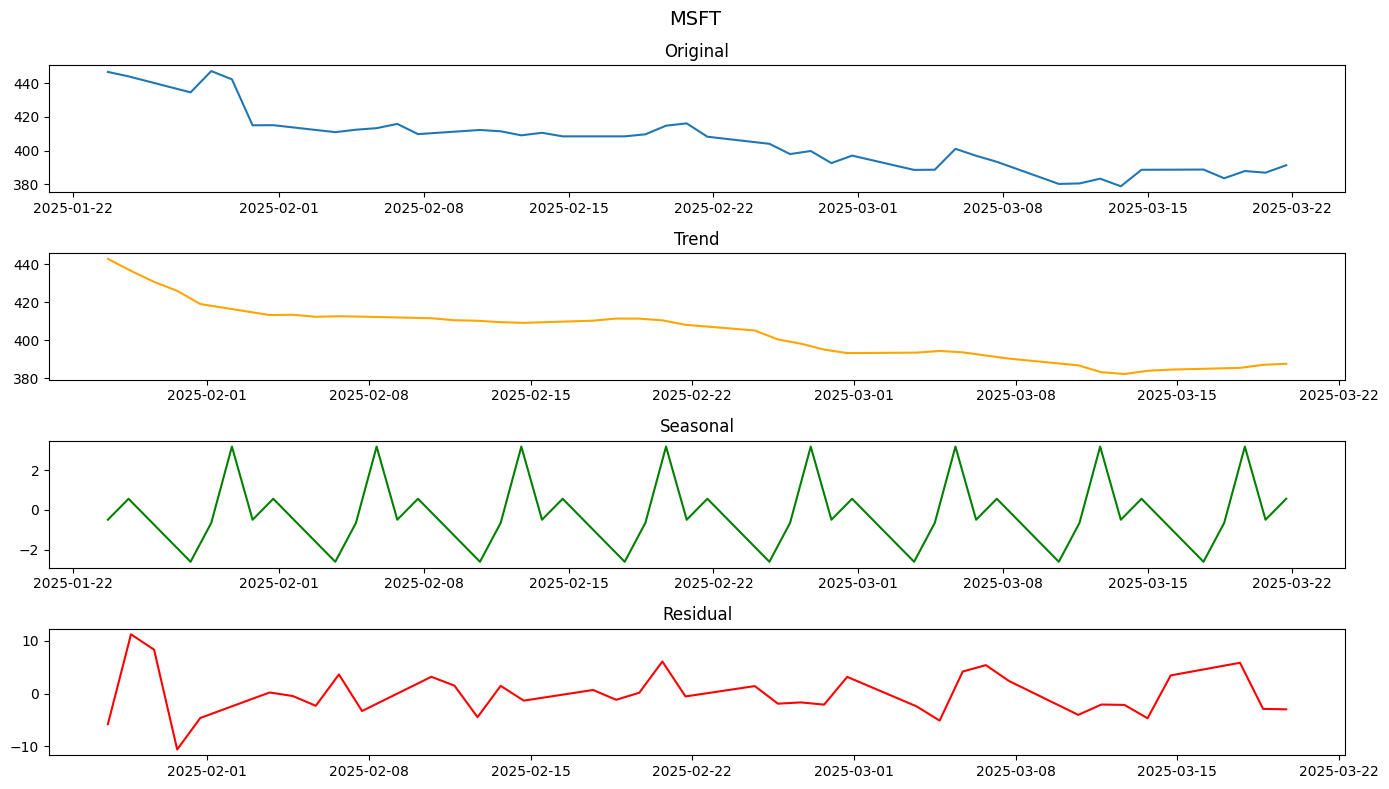

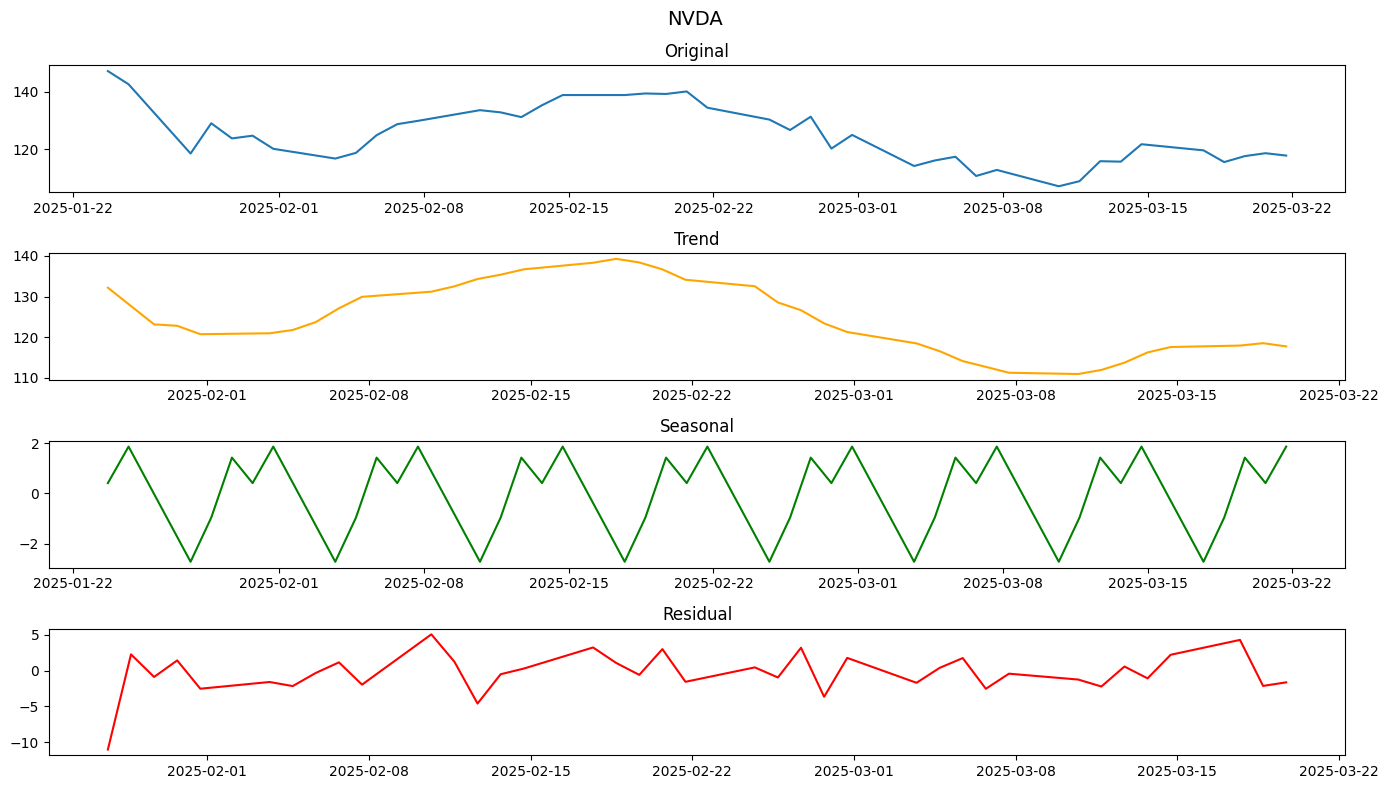

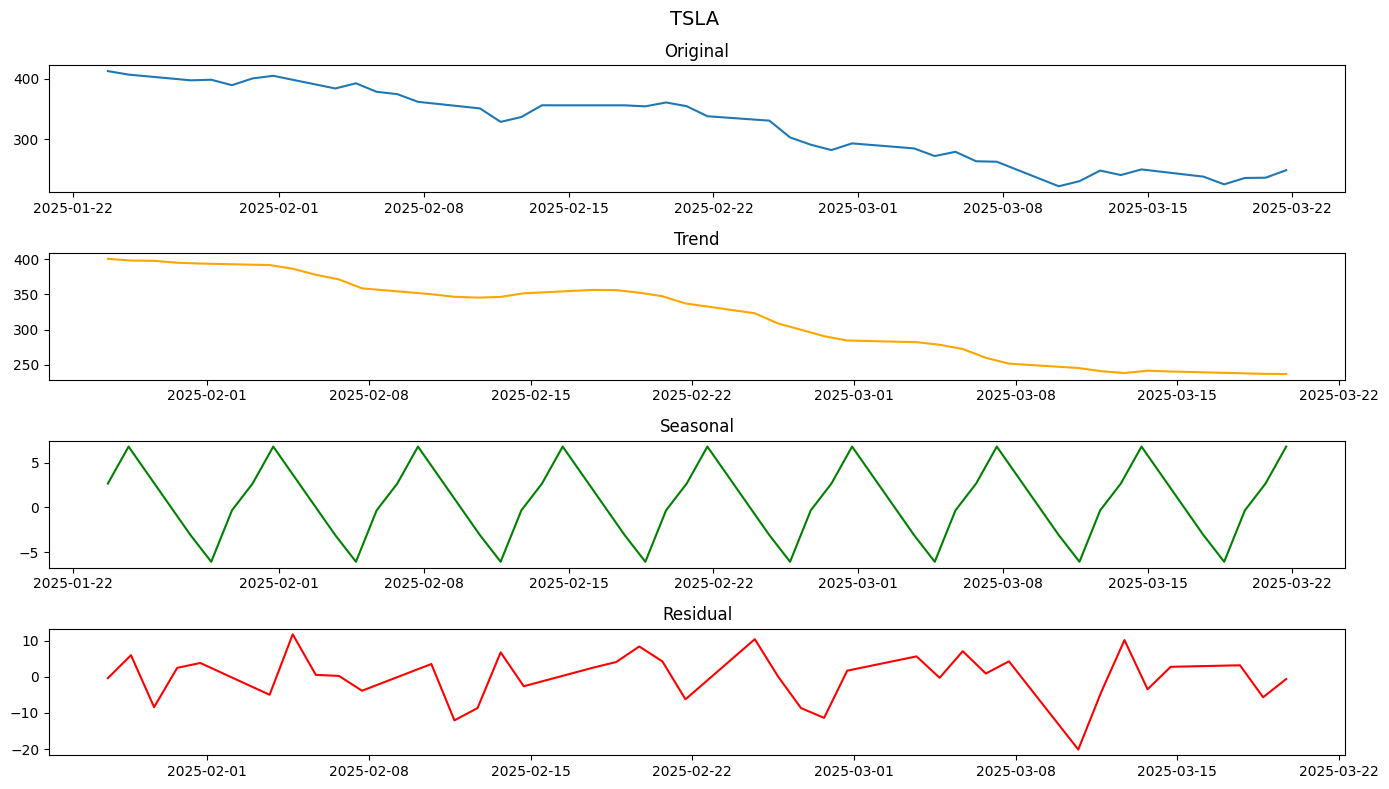

In [6]:
for ticker, decomp in ticker_decomps.items():
    plot_decomp(decomp, ticker)

## Differencing and log transforms

In [7]:
ticker_diffs = {}
for ticker in adj_close_df.columns:
    adj_close = adj_close_df.loc[:, ticker]
    adj_close_log = np.log(adj_close)
    adj_close_log_diff_1 = adj_close_log.diff()
    diff_df = (
        adj_close.to_frame("original")
        .assign(log=adj_close_log)
        .assign(log_diff_1=adj_close_log_diff_1)
    )
    ticker_diffs[ticker] = diff_df

In [8]:
def plot_log_diffs(df, title):
    original_adf_p = adfuller(df["original"].dropna())[1]
    log_adf_p = adfuller(df["log"].dropna())[1]
    log_diff_1_adf_p = adfuller(df["log_diff_1"].dropna())[1]
    fig, axs = plt.subplots(nrows=3, ncols=1, figsize=(14, 8))
    axs[0].plot(df["original"])
    axs[0].set_title(f"original, p={original_adf_p:.4f}")
    axs[1].plot(df["log"], color="orange")
    axs[1].set_ylabel("log")
    axs[1].set_title(f"log, p={log_adf_p:.4f}")
    axs[2].plot(df["log_diff_1"], color="green")
    axs[2].set_ylabel("log, diff")
    axs[2].set_title(f"log diff, p={log_diff_1_adf_p:.4f}")
    fig.suptitle(title, fontsize=14)
    fig.tight_layout()

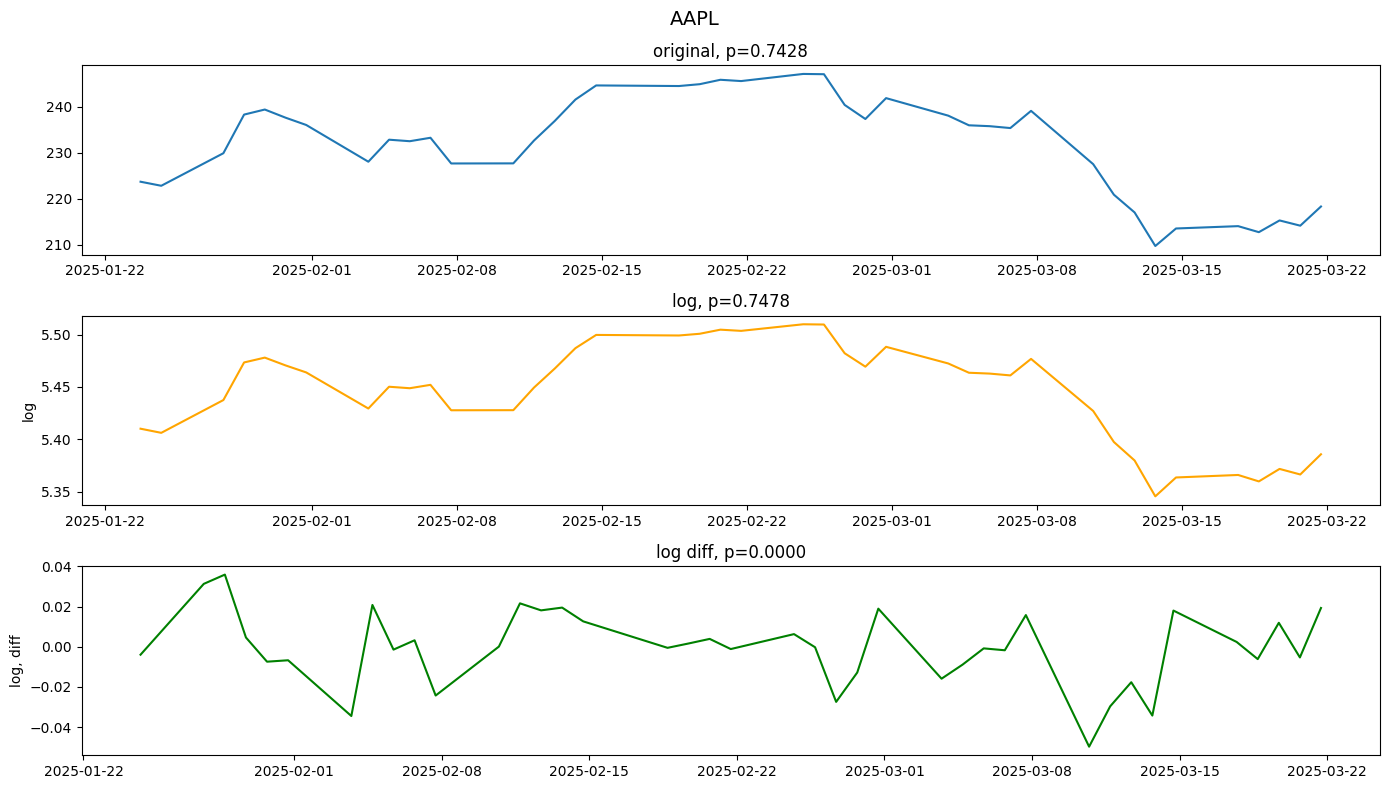

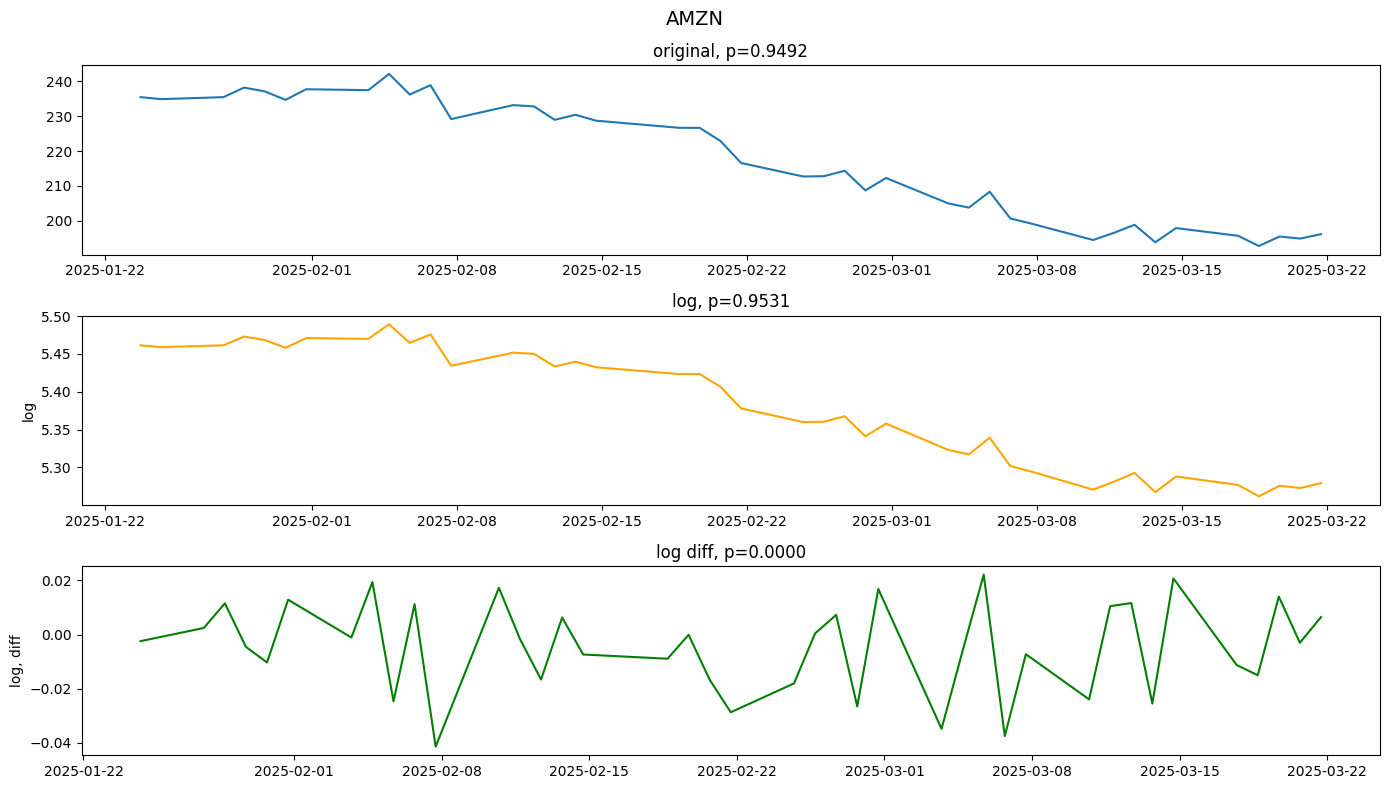

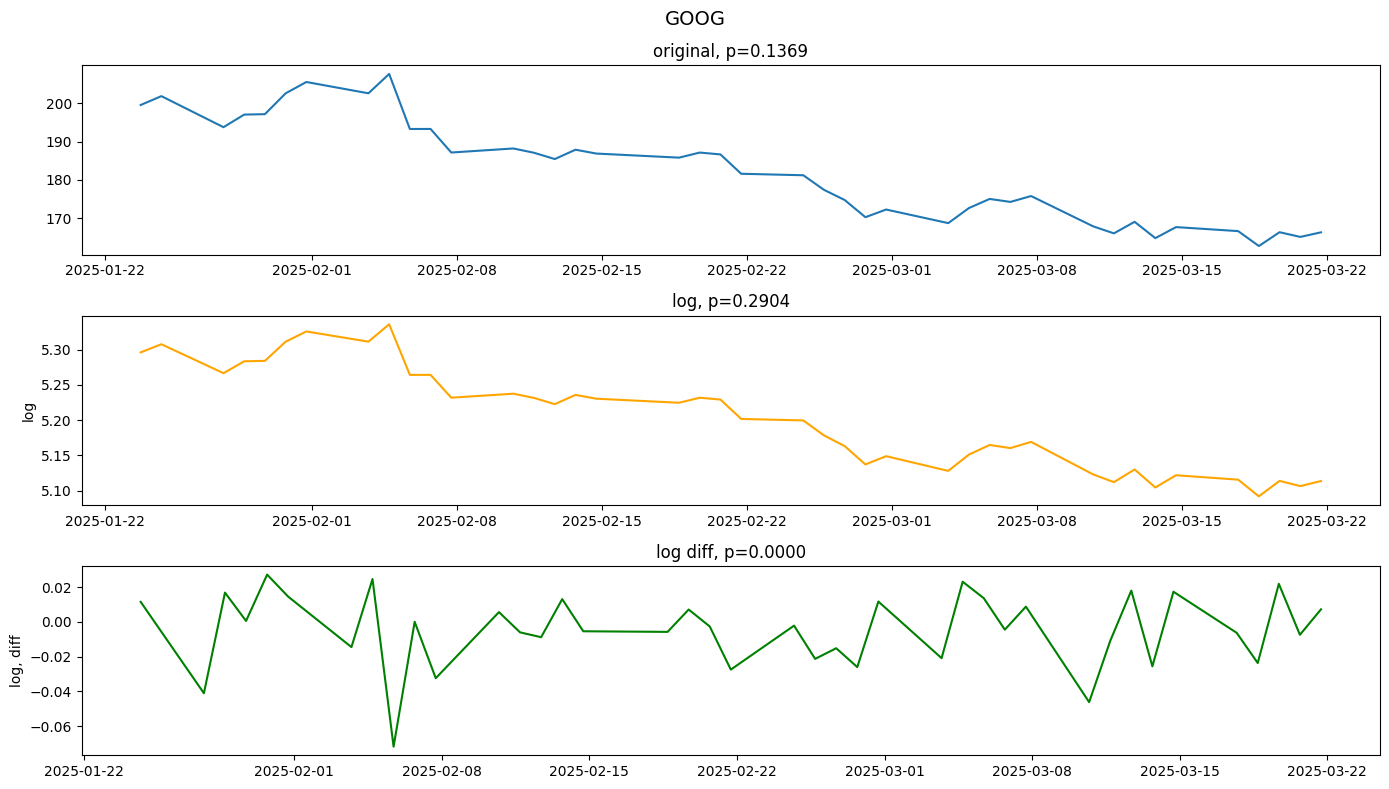

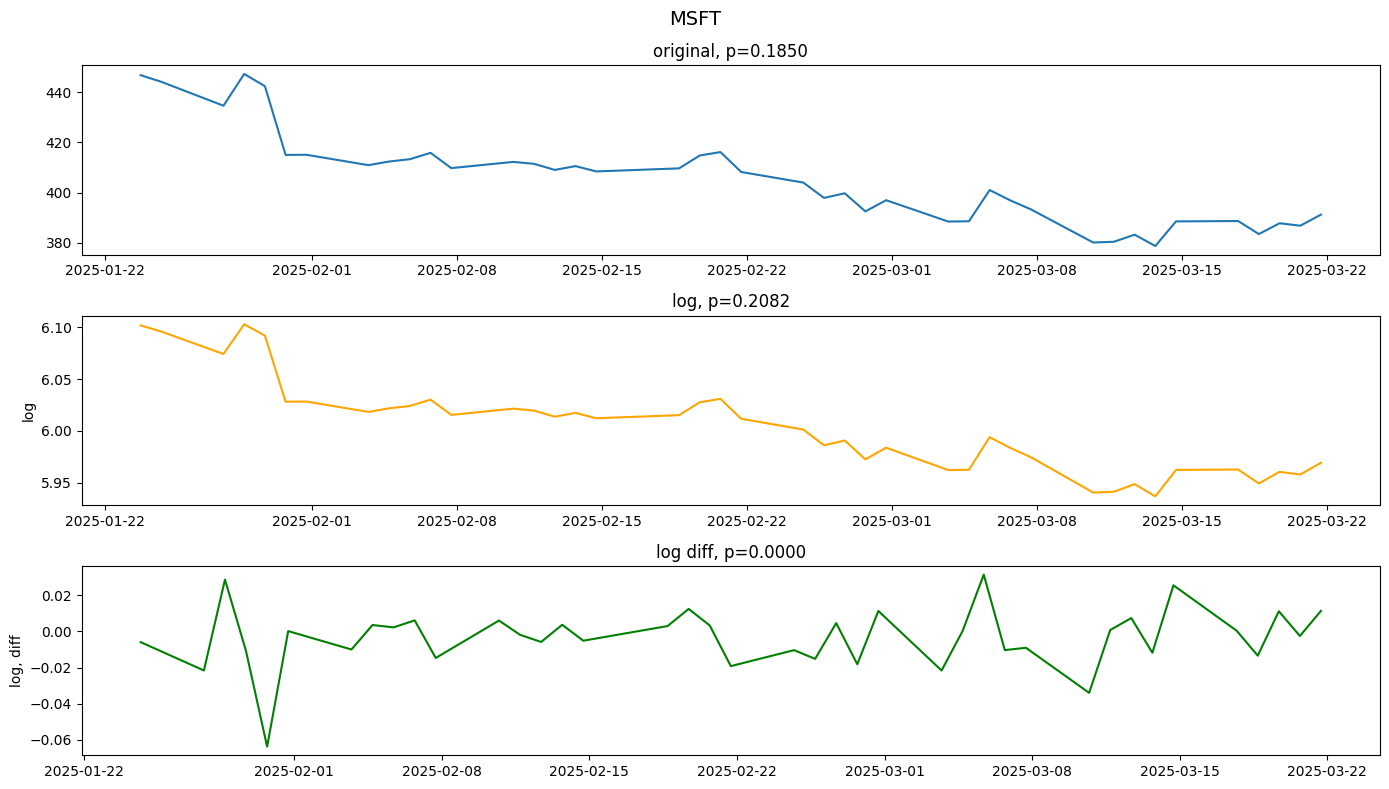

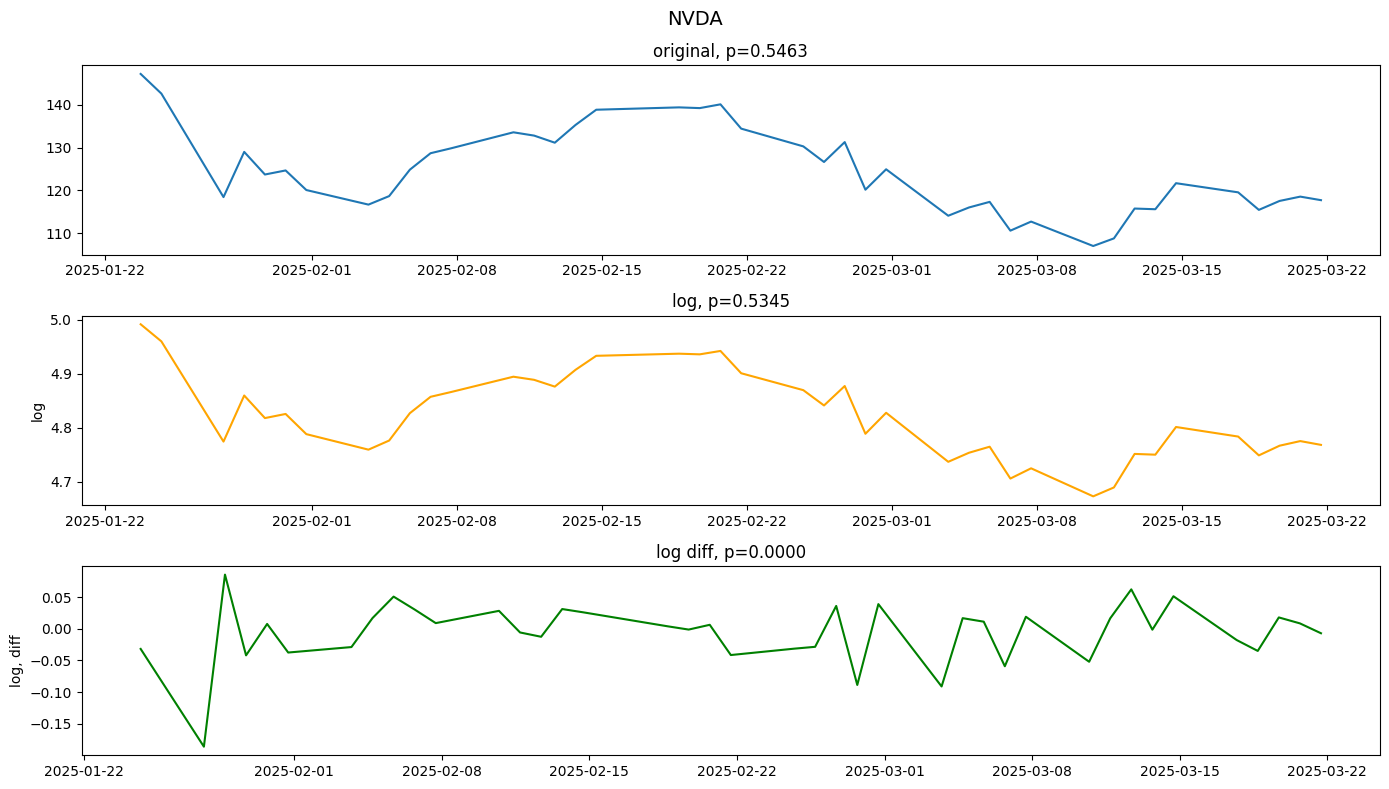

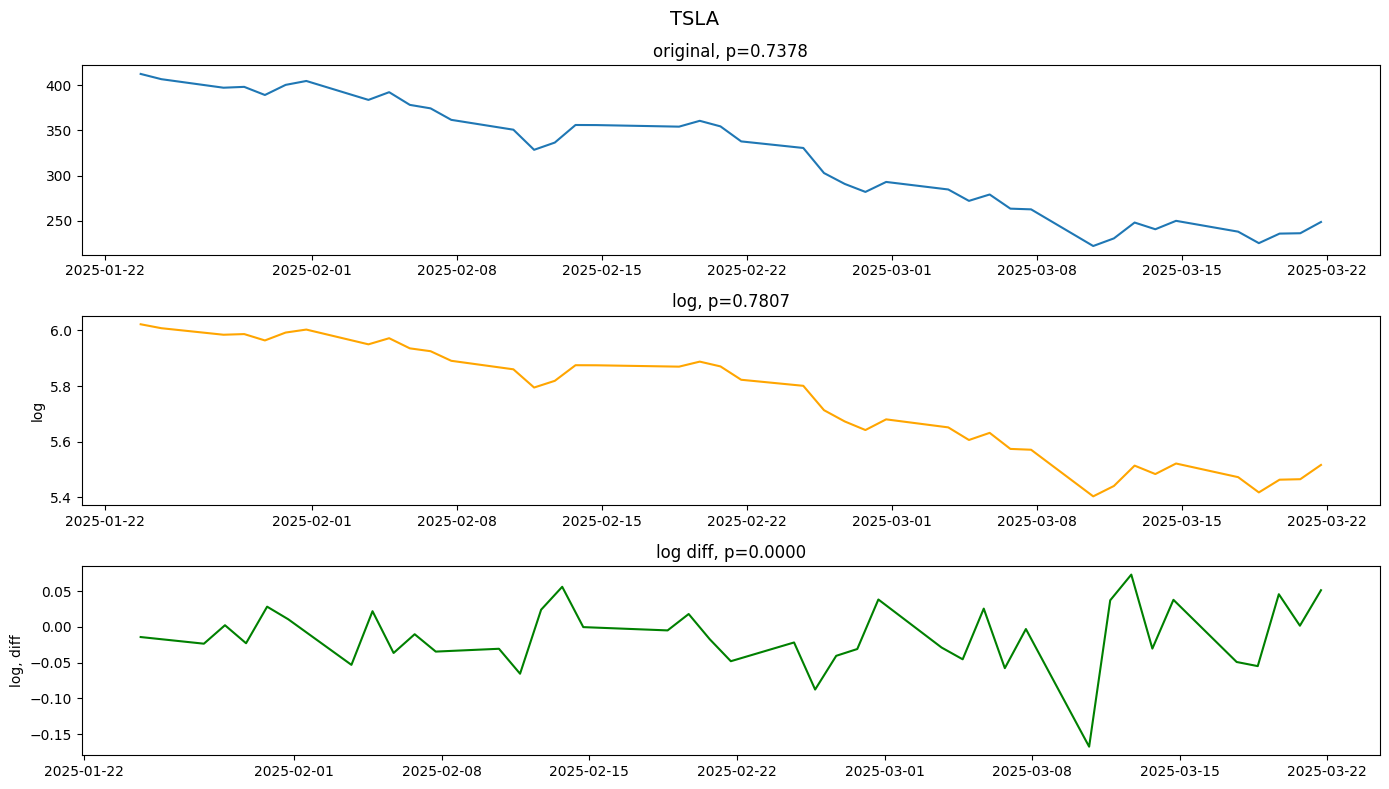

In [9]:
for ticker, d in ticker_diffs.items():
    plot_log_diffs(d, ticker)

## Fit ARIMA models

### First AAPL

Try the functions on AAPL.

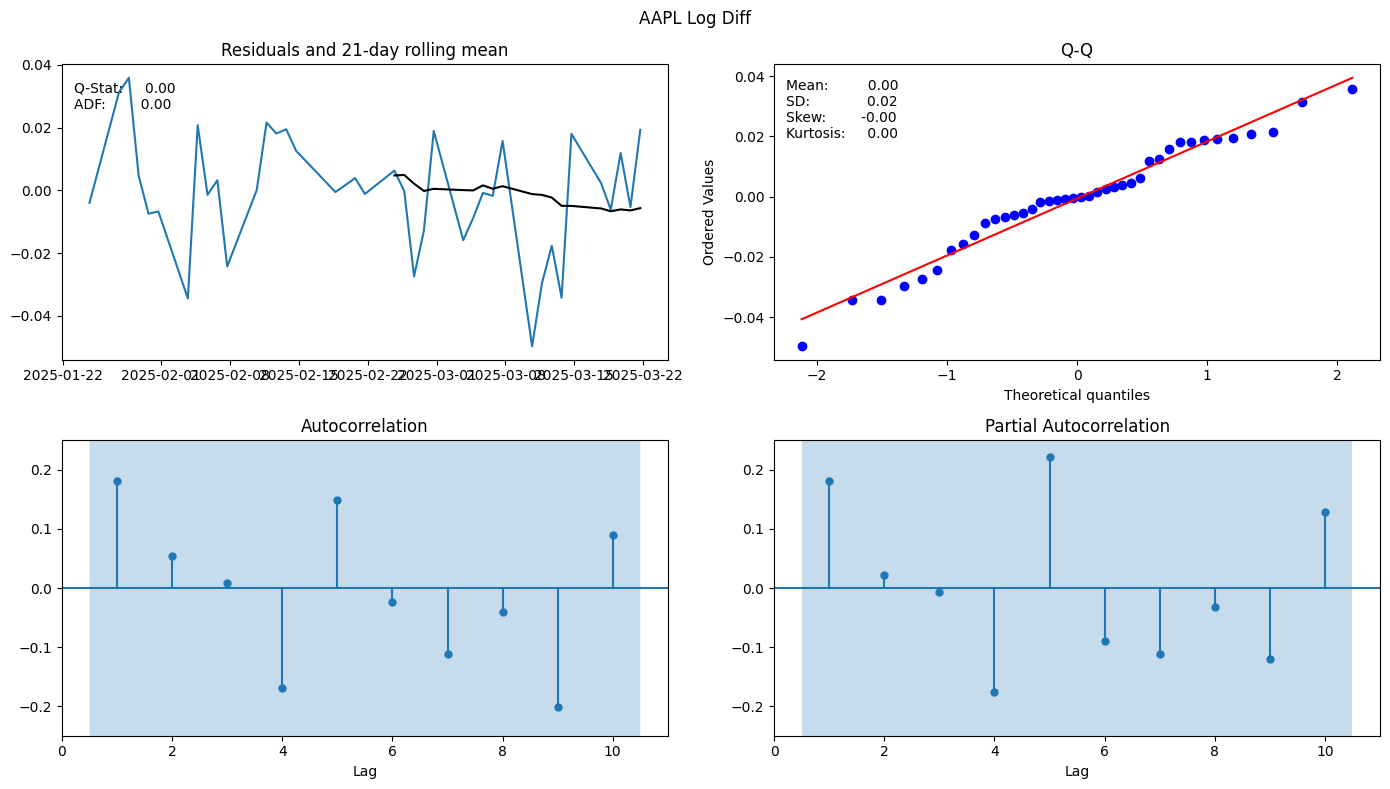

In [10]:
amv = ArimaModelsViz()
aapl = adj_close_df["AAPL"]
amv.plot_log_diff_correlogram(
    aapl, nlags=10, title="AAPL Log Diff", acf_plot_ymax=0.25
)

In [11]:
aapl_arima = ArimaModels()
aapl_arima.fit(aapl, train_len=10)
aapl_arima.train_result

Processing:   0%|          | 0/24 [00:00<?, ?task/s]/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWar

0 1


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

rmse   mean_aic   mean_bic  n_convergence_errors  \
p q                                                         
0 1  0.019596 -50.230609 -49.322853                     0   
1 0  0.020246 -49.244473 -48.336717                     0   
  1  0.021520 -48.720829 -47.510489                     0   
2 0  0.021804 -48.428659 -47.218319                     0   
3 0  0.024816 -47.347525 -45.834600                     0   
1 4  0.022862 -45.948298 -43.830202                     0   
0 3  0.021976 -48.668303 -47.155378                     0   
2 1  0.023882 -48.138775 -46.625849                     0   
  4  0.023877 -44.412793 -41.992112                     0   
0 4  0.022458 -47.897181 -46.081671                     0   
3 1  0.026319 -47.100019 -45.284509                     0   
0 2  0.024047 -49.375507 -48.165167                     0   
1 3  0.023175 -46.952003 -45.136492                     0   
3 2  0.027762 -44.813453 -42.695358                     0   
1 2  0.022750 -47.787954 -46.275028                     0   
3 3  0.027714 -44.046772 -41.626091                     0   
4 3  0.029099 -44.857929 -42.134663                     0   
  1  0.028741 -47.742483 -45.624387                     0   
  2  0.024405 -46.168061 -43.747380                     0   
2 3  0.025172 -45.773040 -43.654945                     0   
3 4  0.025639 -43.063399 -40.340133                     0   
4 0  0.027905 -49.084295 -47.268785                     0   
2 2  0.024045 -46.358238 -44.542728                     0   
4 4  0.029538 -42.446368 -39.420517                     0   

     n_stationarity_errors  
p q                         
0 1                      0  
1 0                      0  
  1                      0  
2 0                      0  
3 0                      0  
1 4                      0  
0 3                      0  
2 1                      0  
  4                      0  
0 4                      0  
3 1                      0  
0 2                      0  
1 3                      0  
3 2                      0  
1 2                      0  
3 3                      0  
4 3                      0  
  1                      0  
  2                      0  
2 3                      0  
3 4                      0  
4 0                      0  
2 2                      0  
4 4                      0

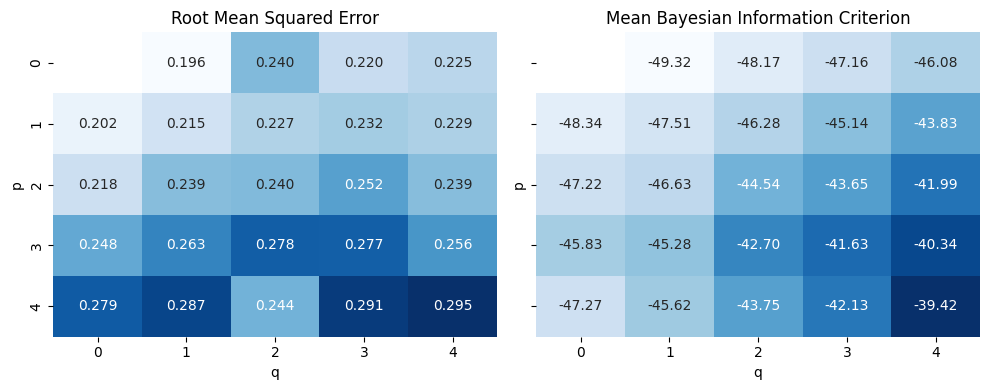

In [12]:
amv.train_arima_viz(aapl_arima)

In [13]:
print(aapl_arima.final_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   AAPL   No. Observations:                   41
Model:                 ARIMA(0, 0, 1)   Log Likelihood                 103.609
Date:                Sun, 23 Mar 2025   AIC                           -201.218
Time:                        21:44:14   BIC                           -196.077
Sample:                             0   HQIC                          -199.346
                                 - 41                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0006      0.004     -0.156      0.876      -0.008       0.006
ma.L1          0.1754      0.152      1.155      0.248      -0.122       0.473
sigma2         0.0003   7.43e-05      4.427      0.0

41


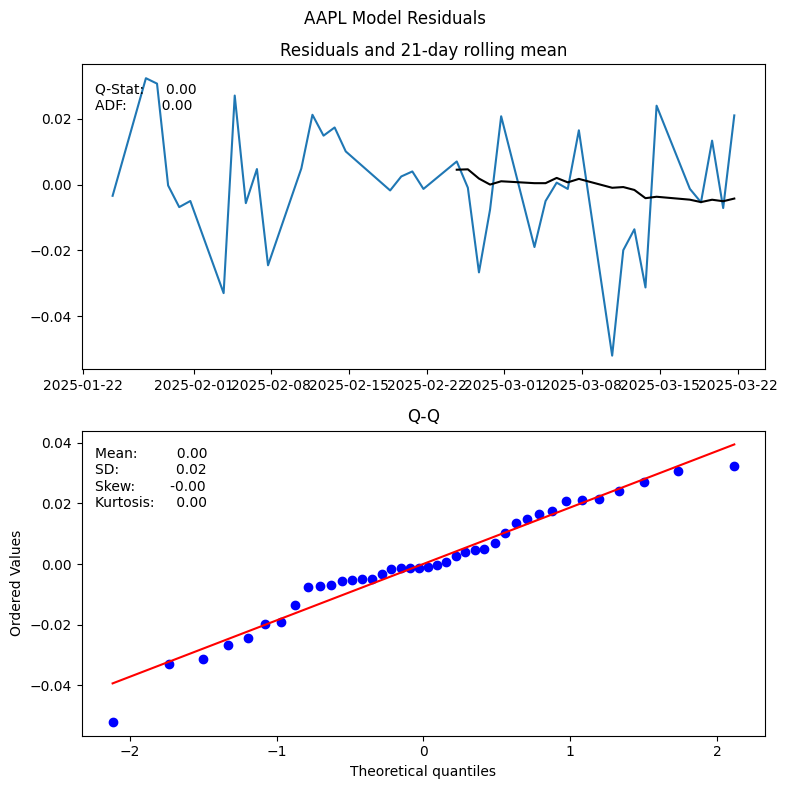

In [14]:
print(len(aapl_arima.final_model.resid))
amv.plot_model_residuals(aapl_arima, title="AAPL Model Residuals", n_lags=1)

### Final foreacast for AAPL

The last adjusted close price the model was trained on was 3/13/2025, so predict the adjusted close price of AAPL on 3/14/2025 (which was ~$213).

In [15]:
aapl_pred = aapl_arima.predict(aapl)
print("AAPL adj close PREDICTION for 3/14/2025", aapl_pred)

AAPL adj close PREDICTION for 3/14/2025 218.95693382805715


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


That is -4 dollars from the actual price!

## Predict all other tickers

`AMZN`, `GOOG`, `MSFT`, `NVDA`, `TSLA`

In [16]:
tickers = ["AMZN", "GOOG", "MSFT", "TSLA"]
preds = {}
for ticker in tickers:
    ticker_ts = adj_close_df[ticker]
    ticker_arima = ArimaModels()
    ticker_arima.fit(ticker_ts, train_len=10)
    preds[ticker] = ticker_arima.predict(ticker_ts)
for ticker, pred in preds.items():
    print(ticker, "adj close PREDICTION", pred)

Processing:   0%|          | 0/24 [00:00<?, ?task/s]/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
Processing: 100%|██████████| 24/24 [00:04<00:00,  5.25task/s]

0 1



/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueW

1 0


/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWa

1 0



/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueW

0 1
AMZN adj close PREDICTION 194.2173767679553
GOOG adj close PREDICTION 164.78987621375848
MSFT adj close PREDICTION 389.1015671953779
TSLA adj close PREDICTION 243.3254514201905



/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/alicia/miniconda3/envs/fuzzy-system-research/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueW

In [17]:
preds

{'AMZN': np.float64(194.2173767679553),
 'GOOG': np.float64(164.78987621375848),
 'MSFT': np.float64(389.1015671953779),
 'TSLA': np.float64(243.3254514201905)}